In [24]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN, Siren
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Clustering, Threshold
from deepymod_torch.training import train
from deepymod_torch.training.sparsity_scheduler import Periodic
from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from math import pi

import matplotlib.pyplot as plt

In [25]:
if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

In [26]:
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.1)

In [28]:
# We need to normalize x and t for SIREN
X_train = X_train.detach()
x_min = torch.tensor([0.5, -3])[None, :]
x_max = torch.tensor([5.0, 4])[None, :]

X_train = (X_train - x_min) / (x_max - x_min) * 2 - 1 

In [29]:
print(X_train.device, y_train.device)

cpu cpu


In [30]:
X_train = X_train.to(device)
y_train = y_train.to(device)

In [31]:
print(X_train.device, y_train.device)

cpu cpu


# Normal NN baseline

In [38]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=1000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True) # Defining optimizer

In [39]:
[tensor.device for tensor in model.parameters()]

[device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu')]

In [40]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, delta=0.01, patience=200, log_dir='runs/test_tb_new/') # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1000     10.00%             467s   -1.17e+01   4.50e-04   5.27e-06   4.09e+00 [tensor([False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False, False])]
       1100     11.00%             509s   -1.20e+01   3.85e-04   3.22e-06   3.11e+00 [tensor([False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False, False])]
       1200     12.00%             541s   -1.22e+01   3.54e-04   2.64e-06   2.34e+00 [tensor([False,  True,  True, False,  True,  True,  True, False,  True, False,
        False, False])]
       1300     13.00%             546s   -1.23e+01   3.44e-04   3.43e-06   1.78e+00 [tensor([False,  True,  True, False, False,  True, False, False,  True, False,
        False, False])]
       1400     14.00%             541s   -1.23e+01   3.39e-04   3.43e-06   1.43e+00 [tensor([False,  True,  True, False, False,  True, False, False, False, Fal

In [25]:
model.sparsity_masks[0].device

device(type='cpu')

In [26]:
model.sparsity_masks[0].to(model.constraint_coeffs()[0].device)

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False])

In [27]:
model.sparsity_masks[0].numel()

12

In [28]:
model.constraint_coeffs(scaled=False, sparse=True)

[tensor([[ 0.0000e+00],
         [-6.8767e-02],
         [ 2.3214e-03],
         [ 6.8197e-06],
         [ 1.6357e+00],
         [-2.2893e-01],
         [-4.1901e-03],
         [ 1.2048e-05],
         [-5.0671e+00],
         [ 2.8476e-01],
         [-8.3380e-05],
         [ 0.0000e+00]], grad_fn=<MaskedScatterBackward>)]

In [31]:
model.constraint_coeffs(scaled=True, sparse=True)

[tensor([[ 0.0000],
         [-0.4252],
         [ 0.6029],
         [ 0.1249],
         [ 0.6169],
         [-0.6450],
         [-0.7590],
         [ 0.1348],
         [-1.0528],
         [ 0.4872],
         [-0.0135],
         [ 0.0000]], grad_fn=<MaskedScatterBackward>)]

In [30]:
model.estimator_coeffs()

[array([[ 0.        ],
        [-0.36233379],
        [ 0.56750077],
        [ 0.11692901],
        [ 0.40710442],
        [-0.67969926],
        [-0.556528  ],
        [ 0.10737118],
        [-0.87586357],
        [ 0.43999882],
        [-0.13300097],
        [ 0.        ]])]

In [22]:
{f'coeff_{idx}': x for idx, x in enumerate(model.estimator_coeffs()[0].squeeze())}

{'coeff_0': 0.0,
 'coeff_1': -0.2243326297697196,
 'coeff_2': 0.5947113739548466,
 'coeff_3': 0.17184257757822993,
 'coeff_4': 0.13502900029369905,
 'coeff_5': -0.6503674552992443,
 'coeff_6': -0.254411440792943,
 'coeff_7': 0.0,
 'coeff_8': -0.3344953691112561,
 'coeff_9': 0.1399014932979103,
 'coeff_10': 0.0,
 'coeff_11': 0.0}

# SIREN 

In [38]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=50, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True) # Defining optimizer

In [39]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/SIREN/') # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
         50      0.50%             398s   -1.17e+01   3.94e-04   1.21e-04   5.08e+00 [tensor([False,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True])]
        150      1.50%             385s   -1.30e+01   2.16e-04   3.41e-05   2.68e+01 [tensor([False,  True, False, False, False,  True, False, False, False, False,
         True,  True])]
        250      2.50%             379s   -1.41e+01   1.22e-04   2.55e-05   1.01e+00 [tensor([False,  True, False,  True, False, False, False, False, False, False,
        False, False])]


KeyboardInterrupt: 

In [28]:
model.library.norms[0][model.constraint.sparsity_masks[0]]

tensor([0.0271, 0.0012, 0.7882, 0.0021, 0.0033])

In [22]:
model.constraint.sparsity_masks[0]

tensor([False, False,  True,  True, False,  True, False,  True, False, False,
        False,  True])

# Derivative

Let's see if we can figure out the derivatives...

In [13]:
# Making data
X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, random=False)

# We need to normalize x and t for SIREN
X_full = X_full.detach()
X_full = (X_full - x_min) / (x_max - x_min) * 2 - 1 
X_full.requires_grad = True

In [81]:
prediction = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)

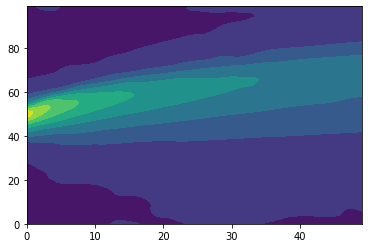

In [82]:
plt.contourf(prediction)

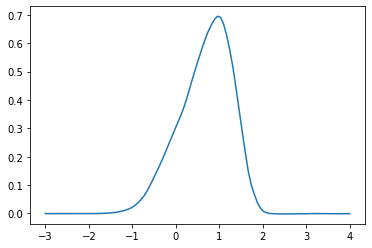

In [83]:
plt.plot(x, prediction[:, 10])

Let's first recreate the forward pass, as it should be similar.

In [86]:
params = list(model.state_dict().items())
n = len(params)
w0 = 30

In [92]:
# Calculating output
output = X_full
for idx in np.arange(0, (n-2), 2):
    output = torch.sin(w0 * (output @ params[idx][1].T + params[idx+1][1]))
output = output @ params[-2][1].T + params[-1][1] # last layer

In [93]:
output = output.cpu().detach().numpy().reshape(x_grid.shape)

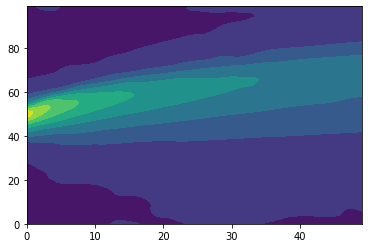

In [94]:
plt.contourf(output)

So that works. Now let's try the derivative w.r.t x:

In [102]:
dt = model(X_full)[1][0].cpu().detach().numpy().reshape(x_grid.shape)

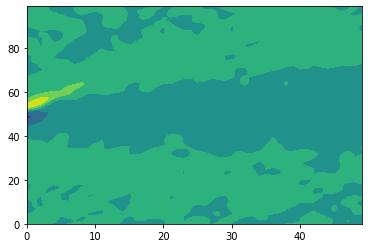

In [103]:
plt.contourf(dt)

In [233]:
params[0][1].shape

torch.Size([30, 2])

In [244]:
params[0][1].T * torch.cat((torch.ones((30, 1)), torch.zeros((30, 1))), dim=1).T

tensor([[ 0.2861, -0.4316, -0.3801,  0.4094, -0.2547,  0.0398,  0.2339, -0.1959,
          0.0193, -0.2911, -0.1235,  0.2528, -0.3539,  0.0121,  0.2756,  0.4324,
          0.2152, -0.1472, -0.0948,  0.2483,  0.2796, -0.1168, -0.1587, -0.0160,
         -0.1142,  0.3377, -0.0663,  0.1773,  0.3289, -0.3618],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000]])

In [251]:
y0 = w0 * (X_full @ (params[0][1].T))# * torch.cat((torch.ones((30, 1)), torch.zeros((30, 1))), dim=1).T))

In [252]:
y0.shape

torch.Size([5000, 30])

In [253]:
y = y0
for l in np.arange(2, (n-2), 2):
    y = torch.sin(y) @ params[l][1].T
y = y @ params[-2][1].T

In [254]:
y.shape

torch.Size([5000, 1])

In [255]:
dt_siren = y.cpu().detach().numpy().reshape(x_grid.shape)

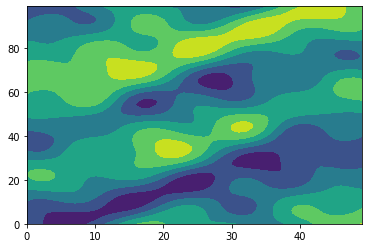

In [256]:
plt.contourf(dt_siren)

In [243]:
dt_siren

array([[ 2.6709763e-09,  2.5634601e-09,  2.2305855e-09, ...,
        -2.2305855e-09, -2.5634503e-09, -2.6709763e-09],
       [ 2.6709763e-09,  2.5634601e-09,  2.2305855e-09, ...,
        -2.2305855e-09, -2.5634503e-09, -2.6709763e-09],
       [ 2.6709763e-09,  2.5634601e-09,  2.2305855e-09, ...,
        -2.2305855e-09, -2.5634503e-09, -2.6709763e-09],
       ...,
       [ 2.6709763e-09,  2.5634601e-09,  2.2305855e-09, ...,
        -2.2305855e-09, -2.5634503e-09, -2.6709763e-09],
       [ 2.6709763e-09,  2.5634601e-09,  2.2305855e-09, ...,
        -2.2305855e-09, -2.5634503e-09, -2.6709763e-09],
       [ 2.6709763e-09,  2.5634601e-09,  2.2305855e-09, ...,
        -2.2305855e-09, -2.5634512e-09, -2.6709803e-09]], dtype=float32)

In [151]:
dt

array([[ 0.00301223,  0.00018283,  0.00904952, ..., -0.00198284,
        -0.00527554, -0.00337931],
       [ 0.00610776, -0.00095966,  0.00660652, ...,  0.0002348 ,
        -0.00367725, -0.00863743],
       [ 0.00549726,  0.00050823,  0.00464874, ..., -0.00010521,
        -0.00269526, -0.01063423],
       ...,
       [ 0.00412243,  0.01918642,  0.02641053, ...,  0.00334355,
         0.00102139, -0.02479341],
       [ 0.00773113,  0.03646746,  0.03469969, ..., -0.00129189,
         0.00782214, -0.01908902],
       [ 0.01276966,  0.05208157,  0.0366562 , ..., -0.00471219,
         0.00867833, -0.00779094]], dtype=float32)

In [3]:
a = [0, 1, 2]

In [6]:
a[-2]

1

In [36]:
from phimal_utilities.analysis import load_tensorboard

In [40]:
df = load_tensorboard('runs/test_3/')

In [41]:
df

""
